# Project: Facial emotion recognition
# MTH767P - Group 4

In [7]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms


ModuleNotFoundError: No module named 'torch'

## Data loading and pre-processing 

In [8]:
def load_data(file_path):
    """
    The function reads the .csv file and adjust and returns x and labels   
       input:
       - `file_path`(str): file location and name
       output:
       - x: data
       - y: labels
    """
    # raead csv
    data = pd.read_csv(file_path)
    # read y
    y = data['emotion'].values
    # adjust x to a npmatrix
    x = data[' pixels'].str.split(' ', expand=True)
    x = x.astype(int).values
    return x, y

def standardize_data(data):
    """
    The function standardize a matrix X   
       input:
       - `data`(np.array): matrix to be standardize 
       output:
       - `data_standardized` (np.array): standardized matrix
    """
    return (data - data.mean(axis=0)) / data.std(axis=0)

def split_data(x, y, ratio=(0.6, 0.2, 0.2)):
    """
    The function split a dataset into a training, validation and test sets
       input:
       - `x`(multidimensinoal np.array(n, m)): data matrix 
       - `y`(unidimensinoal np.array(n,)): data labels
       - `ratio` (tuple): tuple containing the ratio for each set defined as
                          (test portion, validation portion, training portion)
       output:
       - 'x_train, y_train, x_valid, y_valid, x_test, y_test' (np.array): split of the data
    """
    # define len of data
    n = len(x)

    # calculate the indexes
    ix_train = int(ratio[0] * n)
    ix_valid = ix_train + int(ratio[1] * n)
    
    # get training set
    x_train = x[: ix_train, :]
    y_train = y[: ix_train, ]

    # get validation set
    x_valid = x[ix_train : ix_valid, :]
    y_valid = y[ix_train : ix_valid, ]
    
    # get test set
    x_test = x[ix_valid:, :]
    y_test = y[ix_valid:, ]
    return x_train, y_train, x_valid, y_valid, x_test, y_test



#### Read data

In [9]:
_data_path = r'C:\Users\michele.morra\Documents\GitHub\MTH767P_Group4_project\dataset'

# define dictionary for emotions
emotion_dict = {0: 'Angry', 
                1: 'Disgust', 
                2: 'Fear',
                3: 'Happy', 
                4: 'Sad',
                5: 'Surprise',
                6: 'Neutral'}
# load dataset
x, y = load_data(_data_path + '/icml_face_data.csv')



#### Visualize data


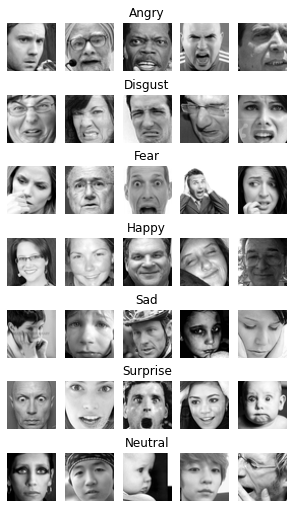

In [27]:
# generate figure

fig, ax = plt.subplots(len(set(y)), 5, figsize=(5, 9))

for e in set(y):
    # get the first 5 images for the emotion e-th
    emotion = x[y == e][:5]
    # set title
    ax[e, 2].set_title(emotion_dict[e])
    for i in range(emotion.shape[0]):      
        # reshape np.array into a 48 by 48 pixel
        im = np.reshape(emotion[i],(48, 48))
        # plot image
        ax[e, i].imshow(im, cmap='gray')
        # hide axis
        ax[e, i].axis('off')
fig.tight_layout;

### Data elaboration


In [31]:
# standardize data
x_std = standardize_data(x)
y_std = standardize_data(y)

# split the data
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(x_std, y_std, ratio=(0.6, 0.4, 0.4))


---
## Convolutional neural network setup 
### Network architecture

In [69]:
class Net(nn.Module):

    def __init__(self, layers, activation, pooling=None):
        super().__init__()
        layer_list = []
        for layer in layers:
            layer_list.append(layer.pop('ltype')(**layer))
        self.layers = nn.ModuleList(layer_list)
        self.activation = activation
        self.pool = pooling

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            print(f'layer {i+1}: {layer}')
            if isinstance(self.layers[i-1], nn.Conv2d) and isinstance(layer, nn.Linear):
                print("flattening")
                x = torch.flatten(x, 1)
            x = layer(x)
            if i != len(self.layers)-1:
                print("activation")
                x = self.activation(x)
                if isinstance(layer, nn.Conv2d) and self.pool is not None:
                    print("pooling")
                    x = self.pool(x)
            print(x)
        return x

In [70]:
# Architecture
l1 = dict(ltype=nn.Conv2d, in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0, groups=1, bias=True, padding_mode='zeros')
l2 = dict(ltype=nn.Conv2d, in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, groups=1, bias=True, padding_mode='zeros')
l3 = dict(ltype=nn.Linear, in_features=400, out_features=120, bias=True)
l4 = dict(ltype=nn.Linear, in_features=120, out_features=84, bias=True)
l5 = dict(ltype=nn.Linear, in_features=84, out_features=10, bias=True)
pooling = nn.MaxPool2d(2)
activation = F.relu
arch = {"layers": [l1,l2,l3,l4,l5], "pooling": pooling, "activation": activation}
net = Net(**arch)

### Loss function and optimizer

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

---
## Training the neural network
### Training

In [ ]:
num_epochs = 2

for epoch in range(num_epochs): 

    running_loss = 0.0
    # FIXME: below line needs to be changed to actual data loader
    for i, data in enumerate(trainloader, 0): 
        # FIXME: make sure the data item does contain both inputs and labels
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

### Cross-validation

In [74]:
# TODO:
# - write cross-validation routine to fine tune hyperparameters

In [ ]:
# Save trained model
PATH = '.'
torch.save(net.state_dict(), PATH)

---
## Testing

In [ ]:
# Load previously trained model
net = Net(**arch)
net.load_state_dict(torch.load(PATH))

In [75]:
# TODO:
# - code prediction function
# - code routine to calculate performance metrics
# - code visualisation of results